In [1]:
! pip install np
! pip install sklearn
! pip install sklearn_nature_inspired_algorithms==0.4.0

In [0]:
from sklearn.metrics import classification_report

# Hyper-Parameter Tunning Using Nature Inspired Algorithms 

In this notebook we will compare the performance of nature inspired search with grid search.

We will use [CoverType](https://archive.ics.uci.edu/ml/datasets/covertype) dataset which can be used for classification tasks.

We will hyper-tune parameters of the RandomForestClassifier.

## Dataset

Firstly, we will load the dataset, since it is really big (and we will make many experiments) we will train only on 1% of its size.

In [3]:
import random

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(download_if_missing=True, return_X_y=True)

# shrink the dataset to the 1% of its original size
rows_id = random.sample(range(0, len(X) - 1), (int)(len(X) * 0.01))

X = X[rows_id, :]
y = y[rows_id]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'train size - {len(X_train)}\ntest size - {len(X_test)}')

train size - 4648
test size - 1162


## Hyper-parameters

Now, we will pick the parameters which we will be optimizing. 

In [0]:
param_grid = { 
    'n_estimators': range(100, 300, 20), 
    'max_depth': [2, 4, 6, 8, 10, 20, 30, 40, 50, 100, 200, 300, 400], 
    'min_samples_split': range(2, 10, 2),
    'max_features': ["auto", "sqrt", "log2"]
}

In [5]:
import numpy as np

print(f'This is {np.multiply.reduce([len(param) for param in param_grid.values()])} combinations in total.')

This is 1560 combinations in total.


## Optimization

### GridSearch

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [7]:
%%time

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1560 candidates, totalling 7800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7800 out of 7800 | elapsed: 138.1min finished


CPU times: user 2h 17min 48s, sys: 15.2 s, total: 2h 18min 3s
Wall time: 2h 18min 9s


In [8]:
grid_search.best_params_

{'max_depth': 40,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 220}

In [9]:
clf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.7946    0.7665    0.7803       424
           2     0.8091    0.8711    0.8389       574
           3     0.7340    0.8625    0.7931        80
           4     1.0000    0.1429    0.2500         7
           5     0.5000    0.0909    0.1538        11
           6     0.6667    0.3077    0.4211        26
           7     0.8462    0.5500    0.6667        40

    accuracy                         0.7969      1162
   macro avg     0.7644    0.5131    0.5577      1162
weighted avg     0.7949    0.7969    0.7891      1162



### NatureInspiredSearch

In [0]:
from sklearn_nature_inspired_algorithms.model_selection.nature_inspired_search_cv import NatureInspiredSearchCV

In [11]:
%%time

clf = RandomForestClassifier(random_state=42)

nia_search = NatureInspiredSearchCV(
    clf,
    param_grid,
    cv=5,
    verbose=0,
    algorithm='hba',
    population_size=25,
    max_n_gen=100,
    max_stagnating_gen=5,
    runs=5,
    scoring='f1_macro'
  )

nia_search.fit(X_train, y_train)

Fitting 5 folds for some of the 1560 candidates, which might total in 7800 fits
CPU times: user 49min 41s, sys: 4.87 s, total: 49min 46s
Wall time: 49min 47s


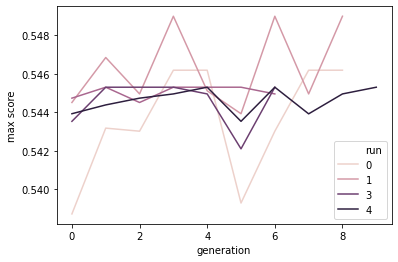

In [13]:
from sklearn_nature_inspired_algorithms.helpers import score_by_generation_lineplot

score_by_generation_lineplot(nia_search)

In [14]:
nia_search.best_params_

{'max_depth': 40,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 220}

In [15]:
clf = RandomForestClassifier(**nia_search.best_params_, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.7946    0.7665    0.7803       424
           2     0.8091    0.8711    0.8389       574
           3     0.7340    0.8625    0.7931        80
           4     1.0000    0.1429    0.2500         7
           5     0.5000    0.0909    0.1538        11
           6     0.6667    0.3077    0.4211        26
           7     0.8462    0.5500    0.6667        40

    accuracy                         0.7969      1162
   macro avg     0.7644    0.5131    0.5577      1162
weighted avg     0.7949    0.7969    0.7891      1162



## Conclusion

As we can see, the neature inspired search found the exectly same solution as the grid search in the shorter amount of time. If we decreased the number of runs for the nature inspired search, or decreased the population size, the duration might be shorter. However we might not find the most optimal solution in that case.

| Algorithm | F1 Macro score  | Search duration |
| ------------ |-------------:|-------------:|
| GridSearchCV | 0.5577 | 2h 17min 48s |
| NatureInspiredSearchCV | 0.5577 | 49min 41s |
